In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objs as go
import seaborn as sns
import itertools
import bs4 as bs
import pickle
import requests

import datetime as dt
from datetime import datetime, timedelta
import time
import timeit
import os
import pandas_datareader.data as pdr
from math import sqrt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import operator
from functools import reduce

import joblib
import pickle

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from tqdm import tqdm
from IPython.display import display, clear_output

In [3]:
from preprocessing import data_preprocessing 
from feature_engineering import feature_engineering
from ts_features import ts_features

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
%matplotlib inline

### Data preprocessing and Feature engineering 

#### S&P 500 index

In [6]:
snp = yf.download('%5EGSPC', start='2010-01-01', end='2023-05-31')
snp.columns = snp.columns.str.lower()

[*********************100%***********************]  1 of 1 completed


### LSTM

In [7]:
torch.manual_seed(42)

In [8]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    device = torch.device("cuda")
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU')

No GPU available, training on CPU


In [9]:
def evaluate_res(predictions, actual) -> dict:
    '''Calculate metrics'''
    metrics_dict = {}
    metrics_dict['RMSE'] = round(sqrt(mean_squared_error(actual, predictions)), 3)
    metrics_dict['MAE'] = round(mean_absolute_error(actual, predictions), 3)
    metrics_dict['MAPE'] = round(mean_absolute_percentage_error(actual, predictions), 3)
    return metrics_dict

#### Multi-step univariate prediction

In [10]:
from LSTM_ts_loaders import TS_loaders

In [11]:
train = snp['adj close'][:'2022-12-31']
valid = snp['adj close']['2023-01-01':'2023-02-28']
test = snp['adj close']['2023-03-01':]

In [12]:
hist = 21
pred_len = 7

In [13]:
dl = TS_loaders(train, valid, n_input=hist, n_output=pred_len)
train_loader, test_loader = dl.loaders(batch_size=1)

In [14]:
cnt1, cnt2 = 0, 0
for i,j in train_loader: cnt1 += 1
for i,j in test_loader: cnt2 += 1
print(cnt1, cnt2)

3245 12


In [15]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.2):
        '''initiating the model'''
        super(LSTM, self).__init__()
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(output_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc= nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        _, hidden = self.encoder(x)
        output_seq = []
        
        for i in range(pred_len):
            if i == 0:
                # for the first step
                decoder_inp = x[:, -1, :]
            else:
                decoder_inp = decoder_outp
            decoder_outp, hidden = self.decoder(decoder_inp.unsqueeze(1), hidden)
            decoder_outp = self.fc(decoder_outp.squeeze(1))
            output_seq.append(decoder_outp)

        return torch.stack(output_seq, dim=1)

In [16]:
def trainig_loop(model, loss_fn, optimizer, 
                 train_loader, test_loader,
                 num_epochs):

    start_time = time.time()
    ttl_train_losses = []
    ttl_test_losses = []
       
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(np.sqrt(loss.item()))

        tr_mean_loss = np.mean(train_losses)
        ttl_train_losses.append(tr_mean_loss)

        model.eval()
        test_losses = []
        with torch.no_grad():
            for X_test_batch, y_test_batch in test_loader:
                y_pred_test = model(X_test_batch)
                test_loss = loss_fn(y_pred_test, y_test_batch)
                test_losses.append(np.sqrt(test_loss.item()))
        test_mean_loss = np.mean(test_losses)
        ttl_test_losses.append(test_mean_loss)

        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, tr_mean_loss, test_mean_loss))

    tr_time = time.time()-start_time
    outp_dict = {'training_time': tr_time,
                 'ttl_train_losses': ttl_train_losses,
                 'ttl_test_losses': ttl_test_losses,
                 'model': model.state_dict()
                 }
    return model, outp_dict

In [17]:
def check_test(ts, last_day='2023-03-09', history=hist):
    ''''''
    week_for_pred = ts.index[ts.index <= last_day][-7:]
    pred_period = ts.index[ts.index <= last_day ][-7-history:]
    test_week_ts = ts[pred_period]
    return test_week_ts

def week_results(test_week, true_week, days):
    ''''''
    pred_lstm = pd.DataFrame(true_week, columns=['true'], index=days)
    pred_lstm['pred'] = test_week
    results_lstm = []

    for d in days:
        results_lstm.append(evaluate_res(pred_lstm[pred_lstm.index <= d]['true'], 
                                       pred_lstm[pred_lstm.index <= d]['pred']))

    return pd.DataFrame(data=results_lstm, index=days).T

In [18]:
params = {'input_dim': 1,
          'hidden_dim': 8,
          'num_layers': 1,
          'output_dim': 1,
          'dropout': 0.2 }

In [19]:
# training     
model = LSTM(**params)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002)
# 0.02

In [20]:
%%time
model, mod_res = trainig_loop(model, loss_fn, optimizer, train_loader, test_loader, num_epochs=200)

  0%|          | 1/200 [00:18<1:02:00, 18.70s/it]

Epoch 0: train RMSE 0.1433, test RMSE 0.1897


  1%|          | 2/200 [00:35<58:39, 17.77s/it]  

Epoch 1: train RMSE 0.1975, test RMSE 0.1536


  2%|▏         | 3/200 [00:52<57:18, 17.46s/it]

Epoch 2: train RMSE 0.1717, test RMSE 0.0786


  2%|▏         | 4/200 [01:09<56:29, 17.29s/it]

Epoch 3: train RMSE 0.1226, test RMSE 0.0601


  2%|▎         | 5/200 [01:27<55:58, 17.22s/it]

Epoch 4: train RMSE 0.0715, test RMSE 0.0344


  3%|▎         | 6/200 [01:44<55:32, 17.18s/it]

Epoch 5: train RMSE 0.0434, test RMSE 0.0246


  4%|▎         | 7/200 [02:01<55:10, 17.15s/it]

Epoch 6: train RMSE 0.0309, test RMSE 0.0238


  4%|▍         | 8/200 [02:18<54:57, 17.17s/it]

Epoch 7: train RMSE 0.0252, test RMSE 0.0241


  4%|▍         | 9/200 [02:35<54:37, 17.16s/it]

Epoch 8: train RMSE 0.0227, test RMSE 0.0242


  5%|▌         | 10/200 [02:53<54:48, 17.31s/it]

Epoch 9: train RMSE 0.0214, test RMSE 0.0241


  6%|▌         | 11/200 [03:11<55:27, 17.60s/it]

Epoch 10: train RMSE 0.0205, test RMSE 0.0239


  6%|▌         | 12/200 [03:29<55:07, 17.60s/it]

Epoch 11: train RMSE 0.0197, test RMSE 0.0236


  6%|▋         | 13/200 [03:47<55:35, 17.84s/it]

Epoch 12: train RMSE 0.0191, test RMSE 0.0234


  7%|▋         | 14/200 [04:05<55:38, 17.95s/it]

Epoch 13: train RMSE 0.0186, test RMSE 0.0231


  8%|▊         | 15/200 [04:23<54:58, 17.83s/it]

Epoch 14: train RMSE 0.0181, test RMSE 0.0229


  8%|▊         | 16/200 [04:41<54:45, 17.85s/it]

Epoch 15: train RMSE 0.0177, test RMSE 0.0227


  8%|▊         | 17/200 [04:59<54:41, 17.93s/it]

Epoch 16: train RMSE 0.0174, test RMSE 0.0224


  9%|▉         | 18/200 [05:16<54:05, 17.83s/it]

Epoch 17: train RMSE 0.0171, test RMSE 0.0222


 10%|▉         | 19/200 [05:34<53:49, 17.84s/it]

Epoch 18: train RMSE 0.0168, test RMSE 0.0220


 10%|█         | 20/200 [05:52<53:14, 17.75s/it]

Epoch 19: train RMSE 0.0166, test RMSE 0.0219


 10%|█         | 21/200 [06:10<53:05, 17.80s/it]

Epoch 20: train RMSE 0.0163, test RMSE 0.0217


 11%|█         | 22/200 [06:27<52:39, 17.75s/it]

Epoch 21: train RMSE 0.0161, test RMSE 0.0215


 12%|█▏        | 23/200 [06:45<52:08, 17.67s/it]

Epoch 22: train RMSE 0.0159, test RMSE 0.0214


 12%|█▏        | 24/200 [07:02<51:36, 17.59s/it]

Epoch 23: train RMSE 0.0158, test RMSE 0.0212


 12%|█▎        | 25/200 [07:21<51:59, 17.82s/it]

Epoch 24: train RMSE 0.0156, test RMSE 0.0211


 13%|█▎        | 26/200 [07:39<51:47, 17.86s/it]

Epoch 25: train RMSE 0.0154, test RMSE 0.0210


 14%|█▎        | 27/200 [07:56<51:07, 17.73s/it]

Epoch 26: train RMSE 0.0153, test RMSE 0.0208


 14%|█▍        | 28/200 [08:14<51:31, 17.97s/it]

Epoch 27: train RMSE 0.0152, test RMSE 0.0207


 14%|█▍        | 29/200 [08:32<50:49, 17.84s/it]

Epoch 28: train RMSE 0.0151, test RMSE 0.0206


 15%|█▌        | 30/200 [08:50<50:31, 17.83s/it]

Epoch 29: train RMSE 0.0149, test RMSE 0.0205


 16%|█▌        | 31/200 [09:07<50:03, 17.77s/it]

Epoch 30: train RMSE 0.0148, test RMSE 0.0204


 16%|█▌        | 32/200 [09:26<50:06, 17.90s/it]

Epoch 31: train RMSE 0.0147, test RMSE 0.0203


 16%|█▋        | 33/200 [09:44<49:57, 17.95s/it]

Epoch 32: train RMSE 0.0146, test RMSE 0.0202


 17%|█▋        | 34/200 [10:01<49:29, 17.89s/it]

Epoch 33: train RMSE 0.0146, test RMSE 0.0201


 18%|█▊        | 35/200 [10:19<49:11, 17.89s/it]

Epoch 34: train RMSE 0.0145, test RMSE 0.0201


 18%|█▊        | 36/200 [10:37<48:57, 17.91s/it]

Epoch 35: train RMSE 0.0144, test RMSE 0.0200


 18%|█▊        | 37/200 [10:55<48:23, 17.81s/it]

Epoch 36: train RMSE 0.0143, test RMSE 0.0199


 19%|█▉        | 38/200 [11:12<47:42, 17.67s/it]

Epoch 37: train RMSE 0.0142, test RMSE 0.0198


 20%|█▉        | 39/200 [11:30<47:17, 17.62s/it]

Epoch 38: train RMSE 0.0142, test RMSE 0.0198


 20%|██        | 40/200 [11:48<47:06, 17.67s/it]

Epoch 39: train RMSE 0.0141, test RMSE 0.0197


 20%|██        | 41/200 [12:05<46:47, 17.66s/it]

Epoch 40: train RMSE 0.0140, test RMSE 0.0196


 21%|██        | 42/200 [12:23<46:36, 17.70s/it]

Epoch 41: train RMSE 0.0140, test RMSE 0.0196


 22%|██▏       | 43/200 [12:41<46:21, 17.72s/it]

Epoch 42: train RMSE 0.0139, test RMSE 0.0195


 22%|██▏       | 44/200 [12:58<45:54, 17.66s/it]

Epoch 43: train RMSE 0.0138, test RMSE 0.0194


 22%|██▎       | 45/200 [13:16<45:39, 17.68s/it]

Epoch 44: train RMSE 0.0138, test RMSE 0.0194


 23%|██▎       | 46/200 [13:34<45:29, 17.72s/it]

Epoch 45: train RMSE 0.0137, test RMSE 0.0193


 24%|██▎       | 47/200 [13:51<45:01, 17.66s/it]

Epoch 46: train RMSE 0.0137, test RMSE 0.0193


 24%|██▍       | 48/200 [14:09<44:44, 17.66s/it]

Epoch 47: train RMSE 0.0136, test RMSE 0.0192


 24%|██▍       | 49/200 [14:27<44:22, 17.63s/it]

Epoch 48: train RMSE 0.0136, test RMSE 0.0192


 25%|██▌       | 50/200 [14:44<44:13, 17.69s/it]

Epoch 49: train RMSE 0.0135, test RMSE 0.0191


 26%|██▌       | 51/200 [15:02<43:54, 17.68s/it]

Epoch 50: train RMSE 0.0135, test RMSE 0.0191


 26%|██▌       | 52/200 [15:20<43:38, 17.69s/it]

Epoch 51: train RMSE 0.0135, test RMSE 0.0190


 26%|██▋       | 53/200 [15:37<43:24, 17.72s/it]

Epoch 52: train RMSE 0.0134, test RMSE 0.0190


 27%|██▋       | 54/200 [15:55<43:00, 17.68s/it]

Epoch 53: train RMSE 0.0134, test RMSE 0.0189


 28%|██▊       | 55/200 [16:13<42:45, 17.69s/it]

Epoch 54: train RMSE 0.0133, test RMSE 0.0189


 28%|██▊       | 56/200 [16:30<42:26, 17.68s/it]

Epoch 55: train RMSE 0.0133, test RMSE 0.0188


 28%|██▊       | 57/200 [16:48<42:12, 17.71s/it]

Epoch 56: train RMSE 0.0133, test RMSE 0.0188


 29%|██▉       | 58/200 [17:06<42:01, 17.75s/it]

Epoch 57: train RMSE 0.0132, test RMSE 0.0187


 30%|██▉       | 59/200 [17:25<42:31, 18.10s/it]

Epoch 58: train RMSE 0.0132, test RMSE 0.0187


 30%|███       | 60/200 [17:43<41:57, 17.98s/it]

Epoch 59: train RMSE 0.0132, test RMSE 0.0187


 30%|███       | 61/200 [18:01<42:08, 18.19s/it]

Epoch 60: train RMSE 0.0131, test RMSE 0.0186


 31%|███       | 62/200 [18:19<41:40, 18.12s/it]

Epoch 61: train RMSE 0.0131, test RMSE 0.0186


 32%|███▏      | 63/200 [18:38<41:27, 18.16s/it]

Epoch 62: train RMSE 0.0131, test RMSE 0.0185


 32%|███▏      | 64/200 [18:56<41:17, 18.22s/it]

Epoch 63: train RMSE 0.0130, test RMSE 0.0185


 32%|███▎      | 65/200 [19:14<40:34, 18.04s/it]

Epoch 64: train RMSE 0.0130, test RMSE 0.0185


 33%|███▎      | 66/200 [19:31<39:58, 17.90s/it]

Epoch 65: train RMSE 0.0130, test RMSE 0.0184


 34%|███▎      | 67/200 [19:49<39:26, 17.79s/it]

Epoch 66: train RMSE 0.0130, test RMSE 0.0184


 34%|███▍      | 68/200 [20:06<39:09, 17.80s/it]

Epoch 67: train RMSE 0.0129, test RMSE 0.0184


 34%|███▍      | 69/200 [20:24<38:42, 17.73s/it]

Epoch 68: train RMSE 0.0129, test RMSE 0.0183


 35%|███▌      | 70/200 [20:43<39:12, 18.10s/it]

Epoch 69: train RMSE 0.0129, test RMSE 0.0183


 36%|███▌      | 71/200 [21:01<38:53, 18.09s/it]

Epoch 70: train RMSE 0.0129, test RMSE 0.0183


 36%|███▌      | 72/200 [21:19<38:29, 18.04s/it]

Epoch 71: train RMSE 0.0129, test RMSE 0.0182


 36%|███▋      | 73/200 [21:37<38:05, 18.00s/it]

Epoch 72: train RMSE 0.0128, test RMSE 0.0182


 37%|███▋      | 74/200 [21:55<37:37, 17.92s/it]

Epoch 73: train RMSE 0.0128, test RMSE 0.0182


 38%|███▊      | 75/200 [22:12<37:05, 17.81s/it]

Epoch 74: train RMSE 0.0128, test RMSE 0.0181


 38%|███▊      | 76/200 [22:30<36:49, 17.82s/it]

Epoch 75: train RMSE 0.0128, test RMSE 0.0181


 38%|███▊      | 77/200 [22:48<36:52, 17.99s/it]

Epoch 76: train RMSE 0.0127, test RMSE 0.0181


 39%|███▉      | 78/200 [23:07<36:57, 18.18s/it]

Epoch 77: train RMSE 0.0127, test RMSE 0.0180


 40%|███▉      | 79/200 [23:25<36:30, 18.10s/it]

Epoch 78: train RMSE 0.0127, test RMSE 0.0180


 40%|████      | 80/200 [23:43<36:16, 18.13s/it]

Epoch 79: train RMSE 0.0127, test RMSE 0.0180


 40%|████      | 81/200 [24:01<36:02, 18.17s/it]

Epoch 80: train RMSE 0.0127, test RMSE 0.0180


 41%|████      | 82/200 [24:19<35:39, 18.13s/it]

Epoch 81: train RMSE 0.0127, test RMSE 0.0179


 42%|████▏     | 83/200 [24:37<35:14, 18.07s/it]

Epoch 82: train RMSE 0.0126, test RMSE 0.0179


 42%|████▏     | 84/200 [24:55<34:48, 18.00s/it]

Epoch 83: train RMSE 0.0126, test RMSE 0.0179


 42%|████▎     | 85/200 [25:13<34:29, 17.99s/it]

Epoch 84: train RMSE 0.0126, test RMSE 0.0178


 43%|████▎     | 86/200 [25:31<34:00, 17.90s/it]

Epoch 85: train RMSE 0.0126, test RMSE 0.0178


 44%|████▎     | 87/200 [25:49<33:35, 17.84s/it]

Epoch 86: train RMSE 0.0126, test RMSE 0.0178


 44%|████▍     | 88/200 [26:06<33:12, 17.79s/it]

Epoch 87: train RMSE 0.0126, test RMSE 0.0178


 44%|████▍     | 89/200 [26:24<32:47, 17.72s/it]

Epoch 88: train RMSE 0.0125, test RMSE 0.0177


 45%|████▌     | 90/200 [26:41<32:22, 17.66s/it]

Epoch 89: train RMSE 0.0125, test RMSE 0.0177


 46%|████▌     | 91/200 [26:59<32:01, 17.63s/it]

Epoch 90: train RMSE 0.0125, test RMSE 0.0177


 46%|████▌     | 92/200 [27:17<31:55, 17.74s/it]

Epoch 91: train RMSE 0.0125, test RMSE 0.0177


 46%|████▋     | 93/200 [27:35<31:43, 17.79s/it]

Epoch 92: train RMSE 0.0125, test RMSE 0.0176


 47%|████▋     | 94/200 [27:52<31:19, 17.74s/it]

Epoch 93: train RMSE 0.0125, test RMSE 0.0176


 48%|████▊     | 95/200 [28:10<31:04, 17.76s/it]

Epoch 94: train RMSE 0.0125, test RMSE 0.0176


 48%|████▊     | 96/200 [28:28<30:43, 17.73s/it]

Epoch 95: train RMSE 0.0125, test RMSE 0.0176


 48%|████▊     | 97/200 [28:46<30:26, 17.73s/it]

Epoch 96: train RMSE 0.0124, test RMSE 0.0176


 49%|████▉     | 98/200 [29:03<30:09, 17.74s/it]

Epoch 97: train RMSE 0.0124, test RMSE 0.0175


 50%|████▉     | 99/200 [29:21<29:44, 17.67s/it]

Epoch 98: train RMSE 0.0124, test RMSE 0.0175


 50%|█████     | 100/200 [29:38<29:23, 17.63s/it]

Epoch 99: train RMSE 0.0124, test RMSE 0.0175


 50%|█████     | 101/200 [29:56<28:59, 17.57s/it]

Epoch 100: train RMSE 0.0124, test RMSE 0.0175


 51%|█████     | 102/200 [30:13<28:37, 17.53s/it]

Epoch 101: train RMSE 0.0124, test RMSE 0.0174


 52%|█████▏    | 103/200 [30:31<28:15, 17.48s/it]

Epoch 102: train RMSE 0.0124, test RMSE 0.0174


 52%|█████▏    | 104/200 [30:48<27:57, 17.47s/it]

Epoch 103: train RMSE 0.0124, test RMSE 0.0174


 52%|█████▎    | 105/200 [31:05<27:35, 17.43s/it]

Epoch 104: train RMSE 0.0123, test RMSE 0.0174


 53%|█████▎    | 106/200 [31:23<27:15, 17.40s/it]

Epoch 105: train RMSE 0.0123, test RMSE 0.0174


 54%|█████▎    | 107/200 [31:40<26:55, 17.38s/it]

Epoch 106: train RMSE 0.0123, test RMSE 0.0173


 54%|█████▍    | 108/200 [31:57<26:36, 17.36s/it]

Epoch 107: train RMSE 0.0123, test RMSE 0.0173


 55%|█████▍    | 109/200 [32:15<26:18, 17.35s/it]

Epoch 108: train RMSE 0.0123, test RMSE 0.0173


 55%|█████▌    | 110/200 [32:32<26:01, 17.35s/it]

Epoch 109: train RMSE 0.0123, test RMSE 0.0173


 56%|█████▌    | 111/200 [32:49<25:44, 17.35s/it]

Epoch 110: train RMSE 0.0123, test RMSE 0.0173


 56%|█████▌    | 112/200 [33:07<25:25, 17.34s/it]

Epoch 111: train RMSE 0.0123, test RMSE 0.0172


 56%|█████▋    | 113/200 [33:24<25:08, 17.34s/it]

Epoch 112: train RMSE 0.0123, test RMSE 0.0172


 57%|█████▋    | 114/200 [33:41<24:49, 17.32s/it]

Epoch 113: train RMSE 0.0123, test RMSE 0.0172


 57%|█████▊    | 115/200 [33:59<24:41, 17.43s/it]

Epoch 114: train RMSE 0.0122, test RMSE 0.0172


 58%|█████▊    | 116/200 [34:17<24:32, 17.53s/it]

Epoch 115: train RMSE 0.0122, test RMSE 0.0172


 58%|█████▊    | 117/200 [34:34<24:13, 17.51s/it]

Epoch 116: train RMSE 0.0122, test RMSE 0.0171


 59%|█████▉    | 118/200 [34:52<23:58, 17.54s/it]

Epoch 117: train RMSE 0.0122, test RMSE 0.0171


 60%|█████▉    | 119/200 [35:09<23:39, 17.52s/it]

Epoch 118: train RMSE 0.0122, test RMSE 0.0171


 60%|██████    | 120/200 [35:27<23:24, 17.55s/it]

Epoch 119: train RMSE 0.0122, test RMSE 0.0171


 60%|██████    | 121/200 [35:45<23:10, 17.60s/it]

Epoch 120: train RMSE 0.0122, test RMSE 0.0171


 61%|██████    | 122/200 [36:02<22:50, 17.57s/it]

Epoch 121: train RMSE 0.0122, test RMSE 0.0170


 62%|██████▏   | 123/200 [36:20<22:32, 17.57s/it]

Epoch 122: train RMSE 0.0122, test RMSE 0.0170


 62%|██████▏   | 124/200 [36:37<22:12, 17.53s/it]

Epoch 123: train RMSE 0.0122, test RMSE 0.0170


 62%|██████▎   | 125/200 [36:55<22:03, 17.65s/it]

Epoch 124: train RMSE 0.0122, test RMSE 0.0170


 63%|██████▎   | 126/200 [37:13<21:50, 17.71s/it]

Epoch 125: train RMSE 0.0121, test RMSE 0.0170


 64%|██████▎   | 127/200 [37:30<21:26, 17.62s/it]

Epoch 126: train RMSE 0.0121, test RMSE 0.0170


 64%|██████▍   | 128/200 [37:48<21:03, 17.55s/it]

Epoch 127: train RMSE 0.0121, test RMSE 0.0169


 64%|██████▍   | 129/200 [38:05<20:43, 17.52s/it]

Epoch 128: train RMSE 0.0121, test RMSE 0.0169


 65%|██████▌   | 130/200 [38:23<20:37, 17.68s/it]

Epoch 129: train RMSE 0.0121, test RMSE 0.0169


 66%|██████▌   | 131/200 [38:41<20:21, 17.71s/it]

Epoch 130: train RMSE 0.0121, test RMSE 0.0169


 66%|██████▌   | 132/200 [38:59<20:04, 17.71s/it]

Epoch 131: train RMSE 0.0121, test RMSE 0.0169


 66%|██████▋   | 133/200 [39:16<19:42, 17.65s/it]

Epoch 132: train RMSE 0.0121, test RMSE 0.0169


 67%|██████▋   | 134/200 [39:34<19:26, 17.67s/it]

Epoch 133: train RMSE 0.0121, test RMSE 0.0168


 68%|██████▊   | 135/200 [39:52<19:05, 17.62s/it]

Epoch 134: train RMSE 0.0121, test RMSE 0.0168


 68%|██████▊   | 136/200 [40:09<18:47, 17.61s/it]

Epoch 135: train RMSE 0.0121, test RMSE 0.0168


 68%|██████▊   | 137/200 [40:27<18:29, 17.62s/it]

Epoch 136: train RMSE 0.0121, test RMSE 0.0168


 69%|██████▉   | 138/200 [40:44<18:13, 17.64s/it]

Epoch 137: train RMSE 0.0121, test RMSE 0.0168


 70%|██████▉   | 139/200 [41:02<17:52, 17.59s/it]

Epoch 138: train RMSE 0.0120, test RMSE 0.0168


 70%|███████   | 140/200 [41:20<17:35, 17.60s/it]

Epoch 139: train RMSE 0.0120, test RMSE 0.0168


 70%|███████   | 141/200 [41:37<17:20, 17.64s/it]

Epoch 140: train RMSE 0.0120, test RMSE 0.0167


 71%|███████   | 142/200 [41:55<17:00, 17.59s/it]

Epoch 141: train RMSE 0.0120, test RMSE 0.0167


 72%|███████▏  | 143/200 [42:12<16:40, 17.56s/it]

Epoch 142: train RMSE 0.0120, test RMSE 0.0167


 72%|███████▏  | 144/200 [42:30<16:25, 17.61s/it]

Epoch 143: train RMSE 0.0120, test RMSE 0.0167


 72%|███████▎  | 145/200 [42:48<16:08, 17.61s/it]

Epoch 144: train RMSE 0.0120, test RMSE 0.0167


 73%|███████▎  | 146/200 [43:05<15:54, 17.67s/it]

Epoch 145: train RMSE 0.0120, test RMSE 0.0167


 74%|███████▎  | 147/200 [43:23<15:41, 17.77s/it]

Epoch 146: train RMSE 0.0120, test RMSE 0.0167


 74%|███████▍  | 148/200 [43:41<15:24, 17.79s/it]

Epoch 147: train RMSE 0.0120, test RMSE 0.0166


 74%|███████▍  | 149/200 [43:59<15:10, 17.86s/it]

Epoch 148: train RMSE 0.0120, test RMSE 0.0166


 75%|███████▌  | 150/200 [44:17<14:56, 17.93s/it]

Epoch 149: train RMSE 0.0120, test RMSE 0.0166


 76%|███████▌  | 151/200 [44:35<14:38, 17.92s/it]

Epoch 150: train RMSE 0.0120, test RMSE 0.0166


 76%|███████▌  | 152/200 [44:53<14:15, 17.83s/it]

Epoch 151: train RMSE 0.0120, test RMSE 0.0166


 76%|███████▋  | 153/200 [45:11<13:58, 17.83s/it]

Epoch 152: train RMSE 0.0120, test RMSE 0.0166


 77%|███████▋  | 154/200 [45:28<13:36, 17.76s/it]

Epoch 153: train RMSE 0.0119, test RMSE 0.0166


 78%|███████▊  | 155/200 [45:46<13:15, 17.68s/it]

Epoch 154: train RMSE 0.0119, test RMSE 0.0165


 78%|███████▊  | 156/200 [46:04<13:04, 17.84s/it]

Epoch 155: train RMSE 0.0119, test RMSE 0.0165


 78%|███████▊  | 157/200 [46:22<12:43, 17.76s/it]

Epoch 156: train RMSE 0.0119, test RMSE 0.0165


 79%|███████▉  | 158/200 [46:40<12:31, 17.89s/it]

Epoch 157: train RMSE 0.0119, test RMSE 0.0165


 80%|███████▉  | 159/200 [46:58<12:13, 17.90s/it]

Epoch 158: train RMSE 0.0119, test RMSE 0.0165


 80%|████████  | 160/200 [47:16<11:57, 17.95s/it]

Epoch 159: train RMSE 0.0119, test RMSE 0.0165


 80%|████████  | 161/200 [47:34<11:40, 17.97s/it]

Epoch 160: train RMSE 0.0119, test RMSE 0.0165


 81%|████████  | 162/200 [47:51<11:20, 17.90s/it]

Epoch 161: train RMSE 0.0119, test RMSE 0.0164


 82%|████████▏ | 163/200 [48:09<10:59, 17.83s/it]

Epoch 162: train RMSE 0.0119, test RMSE 0.0164


 82%|████████▏ | 164/200 [48:27<10:44, 17.90s/it]

Epoch 163: train RMSE 0.0119, test RMSE 0.0164


 82%|████████▎ | 165/200 [48:45<10:24, 17.85s/it]

Epoch 164: train RMSE 0.0119, test RMSE 0.0164


 83%|████████▎ | 166/200 [49:03<10:06, 17.85s/it]

Epoch 165: train RMSE 0.0119, test RMSE 0.0164


 84%|████████▎ | 167/200 [49:22<09:58, 18.14s/it]

Epoch 166: train RMSE 0.0119, test RMSE 0.0164


 84%|████████▍ | 168/200 [49:39<09:37, 18.06s/it]

Epoch 167: train RMSE 0.0119, test RMSE 0.0164


 84%|████████▍ | 169/200 [49:57<09:17, 18.00s/it]

Epoch 168: train RMSE 0.0119, test RMSE 0.0164


 85%|████████▌ | 170/200 [50:15<08:59, 17.97s/it]

Epoch 169: train RMSE 0.0119, test RMSE 0.0163


 86%|████████▌ | 171/200 [50:33<08:36, 17.82s/it]

Epoch 170: train RMSE 0.0118, test RMSE 0.0163


 86%|████████▌ | 172/200 [50:51<08:19, 17.84s/it]

Epoch 171: train RMSE 0.0118, test RMSE 0.0163


 86%|████████▋ | 173/200 [51:08<08:01, 17.84s/it]

Epoch 172: train RMSE 0.0118, test RMSE 0.0163


 87%|████████▋ | 174/200 [51:26<07:43, 17.83s/it]

Epoch 173: train RMSE 0.0118, test RMSE 0.0163


 88%|████████▊ | 175/200 [51:44<07:24, 17.79s/it]

Epoch 174: train RMSE 0.0118, test RMSE 0.0163


 88%|████████▊ | 176/200 [52:02<07:07, 17.80s/it]

Epoch 175: train RMSE 0.0118, test RMSE 0.0163


 88%|████████▊ | 177/200 [52:20<06:49, 17.80s/it]

Epoch 176: train RMSE 0.0118, test RMSE 0.0163


 89%|████████▉ | 178/200 [52:37<06:31, 17.80s/it]

Epoch 177: train RMSE 0.0118, test RMSE 0.0163


 90%|████████▉ | 179/200 [52:55<06:13, 17.76s/it]

Epoch 178: train RMSE 0.0118, test RMSE 0.0162


 90%|█████████ | 180/200 [53:13<05:54, 17.75s/it]

Epoch 179: train RMSE 0.0118, test RMSE 0.0162


 90%|█████████ | 181/200 [53:31<05:37, 17.75s/it]

Epoch 180: train RMSE 0.0118, test RMSE 0.0162


 91%|█████████ | 182/200 [53:48<05:19, 17.73s/it]

Epoch 181: train RMSE 0.0118, test RMSE 0.0162


 92%|█████████▏| 183/200 [54:06<05:03, 17.85s/it]

Epoch 182: train RMSE 0.0118, test RMSE 0.0162


 92%|█████████▏| 184/200 [54:25<04:47, 17.97s/it]

Epoch 183: train RMSE 0.0118, test RMSE 0.0162


 92%|█████████▎| 185/200 [54:42<04:29, 17.94s/it]

Epoch 184: train RMSE 0.0118, test RMSE 0.0162


 93%|█████████▎| 186/200 [55:00<04:10, 17.91s/it]

Epoch 185: train RMSE 0.0118, test RMSE 0.0162


 94%|█████████▎| 187/200 [55:18<03:53, 17.93s/it]

Epoch 186: train RMSE 0.0118, test RMSE 0.0161


 94%|█████████▍| 188/200 [55:36<03:35, 17.98s/it]

Epoch 187: train RMSE 0.0118, test RMSE 0.0161


 94%|█████████▍| 189/200 [55:54<03:17, 17.96s/it]

Epoch 188: train RMSE 0.0118, test RMSE 0.0161


 95%|█████████▌| 190/200 [56:12<02:59, 17.99s/it]

Epoch 189: train RMSE 0.0118, test RMSE 0.0161


 96%|█████████▌| 191/200 [56:30<02:41, 18.00s/it]

Epoch 190: train RMSE 0.0118, test RMSE 0.0161


 96%|█████████▌| 192/200 [56:48<02:23, 17.96s/it]

Epoch 191: train RMSE 0.0117, test RMSE 0.0161


 96%|█████████▋| 193/200 [57:06<02:04, 17.82s/it]

Epoch 192: train RMSE 0.0117, test RMSE 0.0161


 97%|█████████▋| 194/200 [57:24<01:47, 17.89s/it]

Epoch 193: train RMSE 0.0117, test RMSE 0.0161


 98%|█████████▊| 195/200 [57:42<01:29, 17.88s/it]

Epoch 194: train RMSE 0.0117, test RMSE 0.0161


 98%|█████████▊| 196/200 [57:59<01:11, 17.80s/it]

Epoch 195: train RMSE 0.0117, test RMSE 0.0161


 98%|█████████▊| 197/200 [58:17<00:53, 17.74s/it]

Epoch 196: train RMSE 0.0117, test RMSE 0.0160


 99%|█████████▉| 198/200 [58:35<00:35, 17.74s/it]

Epoch 197: train RMSE 0.0117, test RMSE 0.0160


100%|█████████▉| 199/200 [58:52<00:17, 17.74s/it]

Epoch 198: train RMSE 0.0117, test RMSE 0.0160


100%|██████████| 200/200 [59:10<00:00, 17.75s/it]

Epoch 199: train RMSE 0.0117, test RMSE 0.0160
CPU times: user 58min 49s, sys: 10.2 s, total: 59min
Wall time: 59min 10s


#### 1 test week

In [21]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-03-09', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

# with torch.no_grad():
pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
    
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

{'RMSE': 44.042, 'MAE': 35.524, 'MAPE': 0.009}


<AxesSubplot:xlabel='Date'>

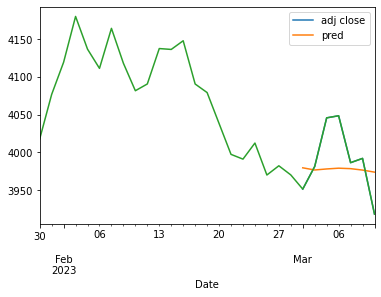

In [22]:
aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot()

#### 2 test week

In [23]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-03-20', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

with torch.no_grad():
    pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

{'RMSE': 63.588, 'MAE': 51.287, 'MAPE': 0.013}


<AxesSubplot:xlabel='Date'>

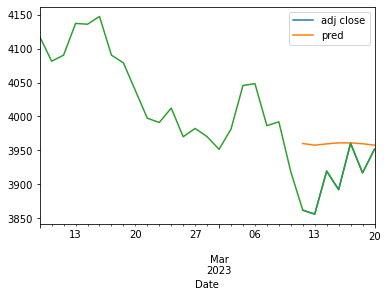

In [24]:
aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot()

#### Random week in future

In [25]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-05-30', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

with torch.no_grad():
    pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

{'RMSE': 66.466, 'MAE': 56.842, 'MAPE': 0.014}


<AxesSubplot:xlabel='Date'>

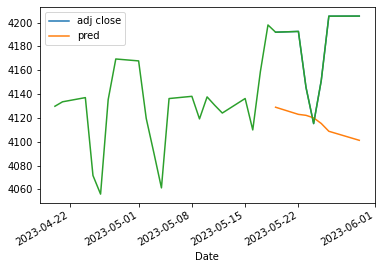

In [26]:
aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot()

In [27]:
%%time
model, mod_res = trainig_loop(model, loss_fn, optimizer, train_loader, test_loader, num_epochs=20)

  5%|▌         | 1/20 [00:17<05:41, 17.96s/it]

Epoch 0: train RMSE 0.0117, test RMSE 0.0160


 10%|█         | 2/20 [00:35<05:15, 17.51s/it]

Epoch 1: train RMSE 0.0117, test RMSE 0.0160


 15%|█▌        | 3/20 [00:52<04:57, 17.49s/it]

Epoch 2: train RMSE 0.0117, test RMSE 0.0160


 20%|██        | 4/20 [01:11<04:47, 17.95s/it]

Epoch 3: train RMSE 0.0117, test RMSE 0.0160


 25%|██▌       | 5/20 [01:28<04:26, 17.74s/it]

Epoch 4: train RMSE 0.0117, test RMSE 0.0160


 30%|███       | 6/20 [01:45<04:05, 17.54s/it]

Epoch 5: train RMSE 0.0117, test RMSE 0.0160


 35%|███▌      | 7/20 [02:03<03:49, 17.67s/it]

Epoch 6: train RMSE 0.0117, test RMSE 0.0159


 40%|████      | 8/20 [02:23<03:40, 18.37s/it]

Epoch 7: train RMSE 0.0117, test RMSE 0.0159


 45%|████▌     | 9/20 [02:40<03:18, 18.02s/it]

Epoch 8: train RMSE 0.0117, test RMSE 0.0159


 50%|█████     | 10/20 [02:57<02:57, 17.74s/it]

Epoch 9: train RMSE 0.0117, test RMSE 0.0159


 55%|█████▌    | 11/20 [03:15<02:38, 17.58s/it]

Epoch 10: train RMSE 0.0117, test RMSE 0.0159


 60%|██████    | 12/20 [03:32<02:19, 17.48s/it]

Epoch 11: train RMSE 0.0117, test RMSE 0.0159


 65%|██████▌   | 13/20 [03:49<02:01, 17.40s/it]

Epoch 12: train RMSE 0.0117, test RMSE 0.0159


 70%|███████   | 14/20 [04:06<01:44, 17.36s/it]

Epoch 13: train RMSE 0.0117, test RMSE 0.0159


 75%|███████▌  | 15/20 [04:24<01:26, 17.37s/it]

Epoch 14: train RMSE 0.0117, test RMSE 0.0159


 80%|████████  | 16/20 [04:41<01:09, 17.32s/it]

Epoch 15: train RMSE 0.0116, test RMSE 0.0159


 85%|████████▌ | 17/20 [04:58<00:51, 17.28s/it]

Epoch 16: train RMSE 0.0116, test RMSE 0.0158


 90%|█████████ | 18/20 [05:15<00:34, 17.27s/it]

Epoch 17: train RMSE 0.0116, test RMSE 0.0158


 95%|█████████▌| 19/20 [05:33<00:17, 17.27s/it]

Epoch 18: train RMSE 0.0116, test RMSE 0.0158


100%|██████████| 20/20 [05:50<00:00, 17.53s/it]

Epoch 19: train RMSE 0.0116, test RMSE 0.0158
CPU times: user 5min 47s, sys: 1.16 s, total: 5min 48s
Wall time: 5min 50s


In [28]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-03-09', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

# with torch.no_grad():
pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
    
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

{'RMSE': 44.823, 'MAE': 36.515, 'MAPE': 0.009}


<AxesSubplot:xlabel='Date'>

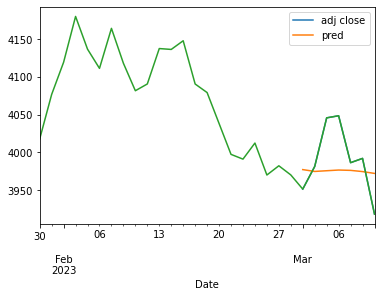

In [29]:
aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot()

In [30]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-03-20', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

with torch.no_grad():
    pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

{'RMSE': 62.543, 'MAE': 50.208, 'MAPE': 0.013}


<AxesSubplot:xlabel='Date'>

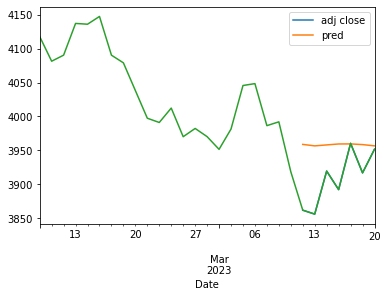

In [31]:
aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot()

In [32]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-05-30', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

with torch.no_grad():
    pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

{'RMSE': 65.087, 'MAE': 55.648, 'MAPE': 0.014}


<AxesSubplot:xlabel='Date'>

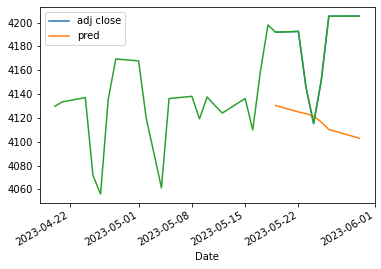

In [33]:
aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot()

In [35]:
path = 'LSTM_seq2seq.pth'
torch.save(model, path)

280 epochs

In [53]:
%%time
model, mod_res = trainig_loop(model, loss_fn, optimizer, train_loader, test_loader, num_epochs=20)

  5%|▌         | 1/20 [00:17<05:29, 17.35s/it]

Epoch 0: train RMSE 0.0114, test RMSE 0.0154


 10%|█         | 2/20 [00:34<05:12, 17.34s/it]

Epoch 1: train RMSE 0.0114, test RMSE 0.0154


 15%|█▌        | 3/20 [00:52<04:54, 17.35s/it]

Epoch 2: train RMSE 0.0114, test RMSE 0.0154


 20%|██        | 4/20 [01:09<04:39, 17.47s/it]

Epoch 3: train RMSE 0.0114, test RMSE 0.0154


 25%|██▌       | 5/20 [01:27<04:21, 17.46s/it]

Epoch 4: train RMSE 0.0114, test RMSE 0.0154


 30%|███       | 6/20 [01:44<04:04, 17.44s/it]

Epoch 5: train RMSE 0.0114, test RMSE 0.0153


 35%|███▌      | 7/20 [02:01<03:46, 17.40s/it]

Epoch 6: train RMSE 0.0114, test RMSE 0.0153


 40%|████      | 8/20 [02:19<03:28, 17.37s/it]

Epoch 7: train RMSE 0.0114, test RMSE 0.0153


 45%|████▌     | 9/20 [02:36<03:10, 17.33s/it]

Epoch 8: train RMSE 0.0114, test RMSE 0.0153


 50%|█████     | 10/20 [02:53<02:53, 17.33s/it]

Epoch 9: train RMSE 0.0114, test RMSE 0.0153


 55%|█████▌    | 11/20 [03:11<02:36, 17.43s/it]

Epoch 10: train RMSE 0.0114, test RMSE 0.0153


 60%|██████    | 12/20 [03:28<02:19, 17.46s/it]

Epoch 11: train RMSE 0.0114, test RMSE 0.0153


 65%|██████▌   | 13/20 [03:46<02:02, 17.51s/it]

Epoch 12: train RMSE 0.0114, test RMSE 0.0153


 70%|███████   | 14/20 [04:04<01:45, 17.50s/it]

Epoch 13: train RMSE 0.0114, test RMSE 0.0153


 75%|███████▌  | 15/20 [04:21<01:27, 17.53s/it]

Epoch 14: train RMSE 0.0114, test RMSE 0.0153


 80%|████████  | 16/20 [04:39<01:09, 17.49s/it]

Epoch 15: train RMSE 0.0114, test RMSE 0.0153


 85%|████████▌ | 17/20 [04:56<00:52, 17.57s/it]

Epoch 16: train RMSE 0.0114, test RMSE 0.0153


 90%|█████████ | 18/20 [05:14<00:35, 17.54s/it]

Epoch 17: train RMSE 0.0114, test RMSE 0.0153


 95%|█████████▌| 19/20 [05:31<00:17, 17.51s/it]

Epoch 18: train RMSE 0.0114, test RMSE 0.0153


100%|██████████| 20/20 [05:49<00:00, 17.47s/it]

Epoch 19: train RMSE 0.0114, test RMSE 0.0153
CPU times: user 5min 47s, sys: 952 ms, total: 5min 48s
Wall time: 5min 49s


{'RMSE': 48.253, 'MAE': 40.03, 'MAPE': 0.01}
CPU times: user 38.5 ms, sys: 17.5 ms, total: 56 ms
Wall time: 171 ms


<AxesSubplot:xlabel='Date'>

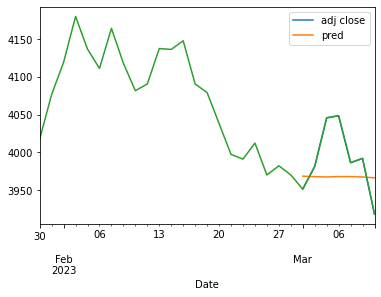

In [54]:
%%time

# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-03-09', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

# with torch.no_grad():
pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
    
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot();

{'RMSE': 58.568, 'MAE': 46.761, 'MAPE': 0.012}


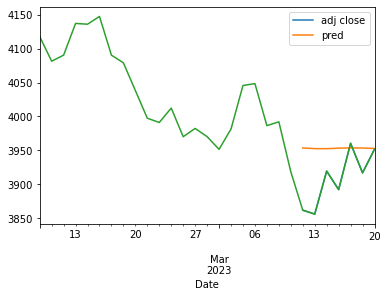

In [55]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-03-20', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

# with torch.no_grad():
pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
    
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot();

{'RMSE': 61.243, 'MAE': 52.309, 'MAPE': 0.013}


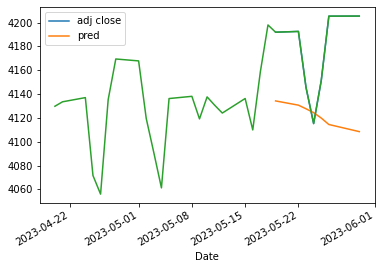

In [56]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-05-30', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

# with torch.no_grad():
pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
    
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot();

In [57]:
path = 'LSTM_seq2seq2.pth'
torch.save(model, path)

{'RMSE': 52.872, 'MAE': 47.521, 'MAPE': 0.012}


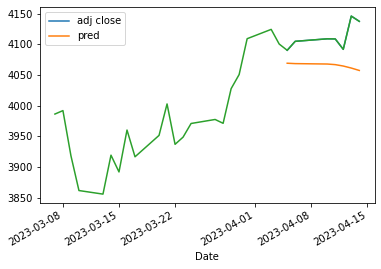

In [59]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-04-15', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

# with torch.no_grad():
pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
    
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot();

{'RMSE': 47.726, 'MAE': 42.349, 'MAPE': 0.01}


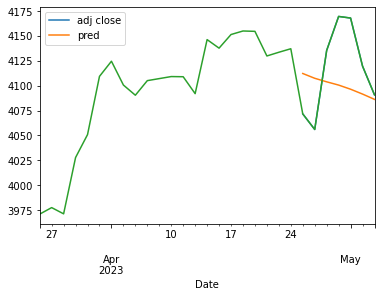

In [61]:
# Check testing period
test_week_ts = check_test(snp['adj close'], last_day='2023-05-03', history=hist)
test_norm = dl.scaling(test_week_ts, action = 'transform')
X_test_week, y_test_week = dl.sliding_windows(test_norm)

# with torch.no_grad():
pred_week = model(torch.tensor(X_test_week)).squeeze(-1)
    
true_week = dl.inv_scaler(y_test_week.reshape(1,-1))[0]
test_week = dl.inv_scaler(pred_week.detach().numpy())[0]

days = test_week_ts[-7:]
print(evaluate_res(true_week, test_week))
# display(week_results(test_week_ts, true_week, days))

aa = test_week_ts[-7:].to_frame()
aa['pred'] = test_week
aa.plot()
test_week_ts.plot();

In [58]:
model

LSTM(
  (encoder): LSTM(1, 8, batch_first=True, dropout=0.2)
  (decoder): LSTM(1, 8, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)